In [26]:
# Todo
# Try to use more of the article
# Compare to country's stock exchange
# Only American stocks
# Sentiment from 1 to 10
# Compare to close price diff according to the article time
#
# Trade
# Trading API


In [25]:
# %pip install openai yfinance --upgrade

In [1]:
import os
import json
import random
import datetime
from dateutil.relativedelta import relativedelta
from dateutil import parser
import requests
from tqdm.auto import tqdm
import pandas as pd
import numpy as np

from openai import OpenAI
import yfinance as yf

In [3]:
j = json.load(open("/root/.aws/secrets.json"))
os.environ["OPENAI_API_KEY"] = j["OPENAI_KEY"]

In [4]:
client = OpenAI()


In [5]:
def get_news(date):
    url = f"https://reuters-business-and-financial-news.p.rapidapi.com/article-date/{date}"

    headers = {
        "X-RapidAPI-Key": "4169c88d67msh97cc35168a11094p1b7c3fjsn872bf1cc2c07",
        "X-RapidAPI-Host": "reuters-business-and-financial-news.p.rapidapi.com"
    }

    response = requests.get(url, headers=headers)
    return response.json()


In [136]:
# company_name = "coca-cola"

In [132]:
# yfinance = "https://query2.finance.yahoo.com/v1/finance/search"
# user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36'
# params = {"q": company_name, "quotes_count": 1, "country": "United States"}

# res = requests.get(url=yfinance, params=params, headers={'User-Agent': user_agent})
# data = res.json()

# company_code = data['quotes'][0]['symbol']


In [137]:
# company_code

In [6]:
GSPC = yf.Ticker("^GSPC")
hist = GSPC.history(start="2014-01-01")
hist['Diff'] = (hist['Close']-hist['Close'].shift(1))/hist['Close']
hist = hist.reset_index()
hist['Date'] = hist['Date'].dt.strftime('%Y-%m-%d')
snp = hist.set_index("Date")
snp.to_csv("data/s&p.txt", sep='\t')


In [6]:
snp = pd.read_csv("data/s&p.txt", sep='\t', index_col=0)

In [183]:
system_prompt = """
You are a financial advisor designed to output JSON. 
The JSON should contain the following fields: a 'stock' field, a 'ticker' field, a 'country' field, a 'action' field, a 'duration' field and 'reasoning' field.
The 'stock' field is a united states traded stock related to the given news article.
The 'ticker' field is the ticker for that stock.
The 'action' field is the action that should be taken based on the article regarding the stock, it should be on a scale from 1 to 10, 1 being strong sell and 10 being strong buy.
The 'reasoning' field is an expanation for the given action.
"""

In [184]:
def get_sentiment(data):
    response = client.chat.completions.create(
      model="gpt-4-1106-preview",
      response_format={ "type": "json_object" },
      messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": f"News article: {data}"},
      ]
    )

    return json.loads(response.choices[0].message.content)
    

In [185]:
NO_TICKER = {"N/A","NONE","VARIES","VARIES","NOT LISTED","VARIOUS","NOT PUBLICLY TRADED","NOT PROVIDED","MULTIPLE","UNKNOWN","PRIVATE COMPANY","PRIVATE","NOT APPLICABLE","PRIVATE","UNAVAILABLE",","}

In [186]:
def is_after_hours(article):
    article_date = article['publishedAt']['date']
    d = parser.parse(article_date)
    return d.hour>=21

In [187]:
def analyse_article(article, date):
    data = f"{article['articlesName']} - {article['articlesShortDescription']}"
    if 'United States' not in [k['keywordName'] for k in article['keywords']]:
        # print('not in US')
        return
    j = get_sentiment(data)
    if j['ticker'] in NO_TICKER or any([x in j['ticker'] for x in NO_TICKER]):
        # print('no ticker')
        return
    ticker = yf.Ticker(j['ticker'])
    # duration = int(j['duration'])

    # before = datetime.date(date.year,date.month,1)
    i = list(snp.index).index(date)
    if is_after_hours(article):
        start = date
        end = snp.iloc[i+2].name
    else:
        start = snp.iloc[i-1].name
        end = snp.iloc[i+1].name
    hist = ticker.history(start=start, end=end)
    if len(hist)==0:
        # print('no hist')
        return 

    ticker_start = hist.iloc[0]
    ticker_end = hist.iloc[-1]
    ticker_diff = (ticker_end['Close']-ticker_start['Close'])/ticker_start['Close']

    snp_start = snp.iloc[list(snp.index).index(start)]
    snp_end = snp.iloc[list(snp.index).index(end)]
    snp_diff = (snp_end['Close']-snp_start['Close'])/snp_start['Close']

    diff = ticker_diff-snp_diff
    return date, data, j['ticker'], j['action'], j['reasoning'], ticker_diff, snp_diff, diff
    

In [188]:
res = []

In [189]:
for i in tqdm(range(100)):
    date = random.choice(snp.index)
    news = get_news(date)
    for _ in range(10):
        try:
            article = random.choice(news)
            analysis = analyse_article(article,date)
            if analysis is None:
                continue

            res += [analysis]
            break
        except Exception as e:
            print(e)
            continue

  0%|          | 0/100 [00:00<?, ?it/s]

SMRT: Data doesn't exist for startDate = 1618977600, endDate = 1619150400
TWTR: No timezone found, symbol may be delisted
WMG: Data doesn't exist for startDate = 1459483200, endDate = 1459828800
Could not get exchangeTimezoneName for ticker '' reason: list index out of range
: No timezone found, symbol may be delisted
LSI: No timezone found, symbol may be delisted
NA: Data doesn't exist for startDate = 1514869200, endDate = 1515042000
NOT PUBLICLY TRADED: No timezone found, symbol may be delisted
SNHJ.J: No timezone found, symbol may be delisted
BID: No timezone found, symbol may be delisted
TWTR: No timezone found, symbol may be delisted
PDVSAC: No timezone found, symbol may be delisted
Could not get exchangeTimezoneName for ticker '' reason: list index out of range
: No timezone found, symbol may be delisted
TWTR: No timezone found, symbol may be delisted
OZON: No timezone found, symbol may be delisted
OZON: No timezone found, symbol may be delisted
OZON: No timezone found, symbol ma

argument of type 'NoneType' is not iterable


TWTR: No timezone found, symbol may be delisted


argument of type 'NoneType' is not iterable


Failed to get ticker 'N/A' reason: Expecting value: line 1 column 1 (char 0)
N/A: No timezone found, symbol may be delisted


In [190]:
df = pd.DataFrame(res) # 

In [191]:
df['action'] = df[3].apply(lambda x: -1 if int(x)<=3 else 1 if int(x)>=8 else 0)

In [ ]:
# df[3].apply(lambda x: x['sentiment'])

In [22]:
D = {"positive":1, 'neutral':0, 'negative':-1}

In [23]:
df['sentiment'] = df[3].apply(lambda x: D[x['sentiment'].lower()])


In [193]:
(df[7]*df['action']).sum()/np.abs(df['action']).sum()

0.028791811540261045

In [32]:
df['sign'] = df[2].apply(lambda x: np.sign(x))

In [194]:
df[7].sum()/len(df)

-0.010821957124515228

In [195]:
df.to_csv('data/news2roi.action.1.tsv', sep='\t', index=0)

<AxesSubplot:xlabel='7', ylabel='action'>

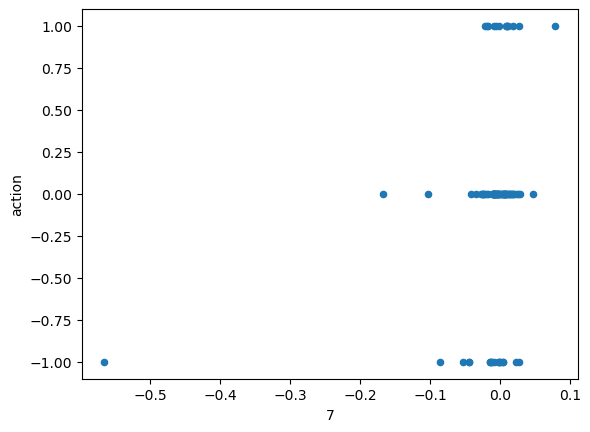

In [197]:
df.plot.scatter(x=7,y='action')

In [166]:
print('hi')

hi


In [200]:
tp = ((df[7]>0) & (df['action']>0)).sum()

In [201]:
tn = ((df[7]<0) & (df['action']<0)).sum()

In [202]:
fp = ((df[7]<0) & (df['action']>0)).sum()

In [203]:
fn = ((df[7]>0) & (df['action']<0)).sum()

In [204]:
acc = (tp+tn)/(tp+tn+fp+fn)

In [205]:
tp,tn,fp,fn,acc

(7, 14, 6, 4, 0.6774193548387096)